# Gym Environments and Implementing Reinforcement Learning Agents with Stable Baselines

<br>
<br>

## The environment

In [3]:
import gymnasium as gym

env_id = "BipedalWalker-v3"
env = gym.make(env_id, hardcore=True)

We chose the `BipedalWalker-v3` environment because it's a continuous action space, and it's (when in hardcore mode) a challenging environment to solve.

<br>
<br>

To see the training progress, we use tensorboard to visualize the training progress and took screenshots of the graphs to use them below. 


<br>


```bash
    tensorboard --logdir=logs
```

<br>

<br>


---


<br>



## The algorithms


In the assignment, to use our environment, we needed to choose a few from the following algorithms:

<br>

- ARS (Augmented Random Search)
- A2C (Advantage Actor Critic)
- DDPG (Deep Deterministic Policy Gradient)
- PPO (Proximal Policy Optimization)
- RecurrentPPO (Recurrent Proximal Policy Optimization)
- SAC (Soft Actor Critic)
- TD3 (Twin Delayed DDPG)
- TQC (Twin Q-Value Critic)
- TRPO (Trust Region Policy Optimization)

<br>
<br>







To see the top 3 algorithms, we trained all of them and chose the best ones:

To train them, we used the following script:


In [8]:
import os
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env

models_dir = "models"
logdir = "logs"
TIMESTEPS = 10**6


def train_model(algo, algo_name, policy, n_envs=os.cpu_count()):
    
    def latest_model(algorithm):
        models = [int(m.split(".")[0]) for m in os.listdir(f"{models_dir}/{algorithm}")]
        models.sort()
        return f"{models_dir}/{algorithm}/{models[-1]}.zip"

    train_env = make_vec_env(env_id, n_envs=n_envs, vec_env_cls=SubprocVecEnv, env_kwargs=dict(hardcore=True),
                       vec_env_kwargs=dict(start_method='fork'))

    if os.path.exists(f"{models_dir}/{algo_name}"):
        if os.listdir(f"{models_dir}/{algo_name}"):

            model_path = latest_model(algo_name)
            model = algo.load(model_path, env=train_env)
            iters = int(int(model_path.split("/")[2].split(".")[0]) / 10 ** 4)
        else:

            model = algo(policy, train_env, verbose=1, tensorboard_log=logdir)
            iters = 0
    else:
        os.makedirs(f"{models_dir}/{algo_name}")
        model = algo(policy, train_env, verbose=1,tensorboard_log=logdir)
        iters = 0

    while True:
        iters += 1
        model.learn(total_timesteps=TIMESTEPS, progress_bar=True, reset_num_timesteps=False,tb_log_name=algo_name)
        model.save(f"{models_dir}/{algo_name}/{TIMESTEPS * iters}")


## Training all the possible models

To train the models, we called the funtion above.

Then we got this graph of the training progress:

![graph](imgs/all_models_original_env.png)


In [69]:
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

def test_performance(model):
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, warn=False)
    return mean_reward

def draw_performance(performances):
    names, values = zip(*performances)
    cmap = plt.get_cmap('Greens')
    colors = [cmap(i / len(names)) for i in range(len(names))]    
    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.bar(names, values, color=colors, alpha=0.7)
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, str(value), ha='center')
    ax.set_title('Performance')    
    plt.legend([f'{name}: {value}' for name, value in performances], loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=len(performances))
    plt.tight_layout()
    plt.show()

Let's test the environment with a random agent from each algorithm:

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


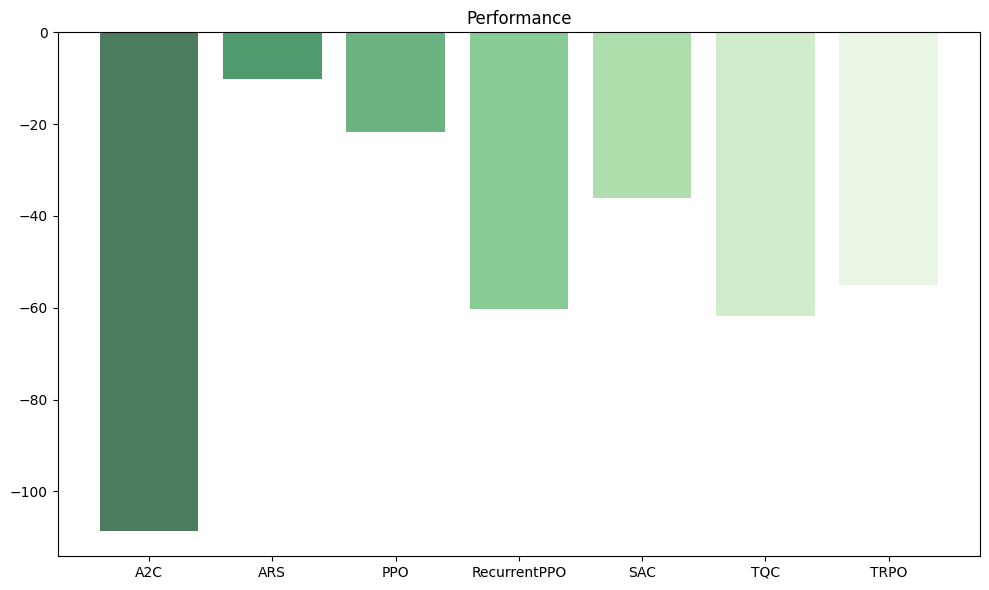

In [70]:
from stable_baselines3 import A2C, PPO, SAC
from sb3_contrib import ARS, RecurrentPPO, TQC, TRPO

draw_performance([("A2C", test_performance(A2C.load("final_models/shallow_trained_original_A2C_original_env.zip", env=env))),
                 ("ARS", test_performance(ARS.load("final_models/shallow_trained_original_ARS_original_env.zip", env=env))),
                 ("PPO", test_performance(PPO.load("final_models/shallow_trained_original_PPO_original_env.zip", env=env))),
                 ("RecurrentPPO", test_performance(RecurrentPPO.load("final_models/shallow_trained_original_RPPO_original_env.zip", env=env))),
                 ("SAC", test_performance(SAC.load("final_models/shallow_trained_original_SAC_original_env.zip", env=env))),
                 ("TQC", test_performance(TQC.load("final_models/shallow_trained_original_TQC_original_env.zip", env=env))),
                 ("TRPO", test_performance(TRPO.load("final_models/shallow_trained_original_TRPO_original_env.zip", env=env)))])


## Deeply training the top 5

<br>

We discarded the models that don't have capabilities to train the environment using SubprocVecEnv, because they are too slow.

<br>
Now let's continue the training with the top five algorithms:

- ARS
- PPO
- SAC
- TRPO
- TQC


<br>
<br>

![graph](imgs/original_models_original_env.png)


<br>

In [ ]:
draw_performance([("ARS", test_performance(ARS.load("final_models/original_ARS_original_env.zip", env=env))),
                  ("PPO", test_performance(PPO.load("final_models/original_PPO_original_env.zip", env=env))),
                  ("SAC", test_performance(SAC.load("final_models/original_SAC_original_env.zip", env=env))),
                  ("TQC", test_performance(TQC.load("final_models/original_TQC_original_env.zip", env=env))),
                  ("TRPO", test_performance(TRPO.load("final_models/original_TRPO_original_env.zip", env=env)))])

# conclusion about the training, change later

<br>

## Creating a RewardWrapper

<br>

We checked, and the problem seems to be that the walker gets stuck in the same place with its legs open.
<br>

![graph](imgs/stuck_walker.png)


To see if we can improve the results, we will try to reward the agent when they stay balanced upright.




In [ ]:
from gymnasium import RewardWrapper as RW


class RewardWrapper(RW):
    def __init__(self, env):
        super().__init__(env)
        self.env = env

    def step(self, action):
        # Perform the environment step
        obs, reward, done, _, info = self.env.step(action)

        # Add a reward for keeping balance
        # obs[2] is the angle of the agent from the vertical position
        balance_reward = abs(obs[2])
        reward += balance_reward

        return obs, reward, done, _, info

To train the models, with the RewardWrapper we need to change the environment creation in the training script:

<br>

```python
env = make_vec_env(env_id, n_envs=NUM_ENVS, wrapper_class=RewardWrapper, vec_env_cls=SubprocVecEnv, vec_env_kwargs=dict(start_method='fork'), env_kwargs=dict(hardcore=True))
```

<br>

Now let's train the models again and check the results.
<br>

![graph](imgs/original_models_wrapped_env.png)

In [ ]:
draw_performance([("ARS", test_performance(ARS.load("final_models/original_ARS_wrapped_env.zip", env=env))),
                  ("PPO", test_performance(PPO.load("final_models/original_PPO_wrapped_env.zip", env=env))),
                  ("SAC", test_performance(SAC.load("final_models/original_SAC_wrapped_env.zip", env=env))),
                  ("TQC", test_performance(TQC.load("final_models/original_TQC_wrapped_env.zip", env=env))),
                  ("TRPO", test_performance(TRPO.load("final_models/original_TRPO_wrapped_env.zip", env=env)))])

# conclusion about the training, change later

## Tuning Hyperparameters

We turned the hyperparameters of the models to see if we could improve the results.


```python

model = algo(policy, env, verbose=1, tensorboard_log=logdir)  # (hyperparameter) ,learning_rate=0.0001, (Neural Network Architecture change)(Neural Network Architecture change) policy_kwargs=dict(net_arch=[256,(...n_layers...), 256]))


model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=algo_name)  # (hyperparameters) , batch_size=256, ent_coef=0.01, vf_coef=0.5, gae_lambda=0.95))

```


Now let's train the models again and check the results.


![graph](imgs/tunned_models_wrapped_env.png)


In [ ]:
draw_performance([("ARS", test_performance(ARS.load("final_models/tunned_ARS_wrapped_env.zip", env=env))),
                  ("PPO", test_performance(PPO.load("final_models/tunned_PPO_wrapped_env.zip", env=env))),
                  ("SAC", test_performance(SAC.load("final_models/tunned_SAC_wrapped_env.zip", env=env))),
                  ("TQC", test_performance(TQC.load("final_models/tunned_TQC_wrapped_env.zip", env=env))),
                  ("TRPO", test_performance(TRPO.load("final_models/tunned_TRPO_wrapped_env.zip", env=env)))])

# CONCLUSIONS ABOUT THE TRAINING CHANGE LATER

## Visualising the best model

Now let's visualize the performance of the best model

In [ ]:
def visualize_model():
    test_env =  gym.make('BipedalWalker-v3', hardcore=True, render_mode="human")
    
    model = PPO.load("final_models/original_PPO_wrapped_env.zip", env=test_env)
    obs, info = test_env.reset()
    
    while True:
        action, _states = model.predict(obs)
        obs, rewards, terminated, truncated, info = test_env.step(action)
        test_env.render()
        if terminated or truncated:
            break
        
visualize_model()